In [17]:
%load_ext autoreload
%autoreload 2
import torch as t
from torch.distributions import Normal
import torch.nn as nn
import bayesfunc as bf
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RuntimeError: Numpy is not available

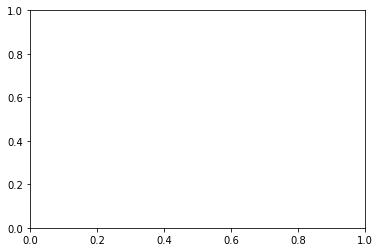

In [18]:
# Generate data
in_features = 1
out_features = 1
train_batch = 40

t.manual_seed(0)
X = t.zeros(train_batch, in_features)
X[:int(train_batch/2), :] = t.rand(int(train_batch/2), in_features)*2. - 4.
X[int(train_batch/2):, :] = t.rand(int(train_batch/2), in_features)*2. + 2.
y = X**3. + 3*t.randn(train_batch, in_features)

#Rescale the outputs to have unit variance
scale = y.std()
y = y/scale

dtype=t.float64
device="cpu"

X = X.to(dtype=dtype, device=device)
y = y.to(dtype=dtype, device=device)

plt.scatter(X, y)

In [21]:
def train(net):
    opt = t.optim.Adam(net.parameters(), lr=0.05)
    samples = 10
    for i in range(2000):
        opt.zero_grad()
        output, logpq, _ = bf.propagate(net, X.expand(samples, -1, -1))
        ll = Normal(output, 3/scale).log_prob(y).sum(-1).mean(-1)
        assert ll.shape == (samples,)
        assert logpq.shape == (samples,)
        
        elbo = ll + logpq/train_batch
        
        (-elbo.mean()).backward()
        print(f"-elbo: {-elbo.mean()} - ll: {ll.mean()} - logpq: {(logpq).mean()}")
        opt.step()
    print(elbo.mean().item())
        
def plot(net):
    with t.no_grad():
        xs = t.linspace(-6,6,100)[:, None].to(device=device, dtype=dtype)
        print(xs.shape)
        #set sample=100, so we draw 100 different functions
        ys, _, _ = bf.propagate(net, xs.expand(100, -1, -1))
        mean_ys = ys.mean(0)
        std_ys = ys.std(0)
        plt.fill_between(xs[:, 0], mean_ys[:, 0]-2*std_ys[:, 0], mean_ys[:, 0]+2*std_ys[:, 0], alpha=0.5)
        plt.plot(xs, mean_ys)
        plt.scatter(X, y, c='r')



Mean-field variational inference
======

torch.Size([100, 1])


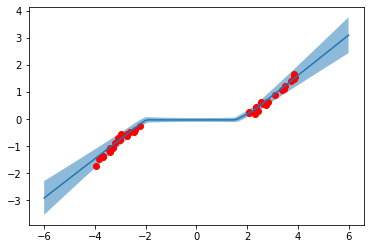

In [17]:
net = nn.Sequential(
    bf.FactorisedLinear(in_features=1, out_features=50, bias=True),
    nn.ReLU(),
    bf.FactorisedLinear(in_features=50, out_features=50, bias=True),
    nn.ReLU(),
    bf.FactorisedLinear(in_features=50, out_features=1, bias=True)
)
net = net.to(device=device, dtype=dtype)
train(net)
plot(net)

Local-inducing with Bayesian neural networks
=======

-8.464810080607569
torch.Size([100, 1])


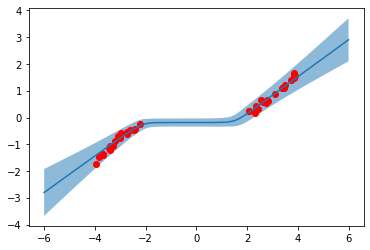

In [5]:
net = nn.Sequential(
    bf.LILinear(in_features=1, out_features=50, bias=True),
    nn.ReLU(),
    bf.LILinear(in_features=50, out_features=50, bias=True, full_prec=True),
    nn.ReLU(),
    bf.LILinear(in_features=50, out_features=1, bias=True, full_prec=True)
)
net = net.to(device=device, dtype=dtype)
train(net)
plot(net)

Global-inducing with Bayesian neural networks
=====

In [22]:
inducing_batch=40
net = nn.Sequential(
    bf.GILinear(in_features=1, out_features=50, inducing_batch=inducing_batch, bias=True),
    nn.ReLU(),
    bf.GILinear(in_features=50, out_features=50, inducing_batch=inducing_batch, bias=True),
    nn.ReLU(),
    bf.GILinear(in_features=50, out_features=1, inducing_batch=inducing_batch, bias=True, full_prec=True)
)
net = bf.InducingWrapper(net, inducing_batch=inducing_batch, inducing_data=t.linspace(-4, 4, inducing_batch)[:, None])
net = net.to(device=device, dtype=dtype)
train(net)
plot(net)

-elbo: 105.93076846735326 - ll: -105.601961960247 - logpq: -13.152260284249303
-elbo: 70.01393700170404 - ll: -69.64952081215327 - logpq: -14.576647582030791
-elbo: 53.34831299805554 - ll: -52.90610425937816 - logpq: -17.688349547095108
-elbo: 56.836417042921354 - ll: -56.40710503436551 - logpq: -17.17248034223363
-elbo: 27.54409675929541 - ll: -27.07833243031041 - logpq: -18.630573159400093
-elbo: 49.18205827190367 - ll: -48.72811513931451 - logpq: -18.157725303566117
-elbo: 21.972092369621443 - ll: -21.467227376616044 - logpq: -20.194599720215912
-elbo: 21.216223248142093 - ll: -20.664873950472092 - logpq: -22.053971906799823
-elbo: 13.73968321153011 - ll: -13.157979964002559 - logpq: -23.268129901101982
-elbo: 15.149221897675698 - ll: -14.582032056687297 - logpq: -22.687593639536136
-elbo: 11.35053586996229 - ll: -10.731582492996544 - logpq: -24.758135078629728
-elbo: 13.272487778542876 - ll: -12.598167138419672 - logpq: -26.972825604928136
-elbo: 13.157197000010623 - ll: -12.487338

KeyboardInterrupt: 

Local-inducing with Gaussian processes
========

torch.Size([100, 1])


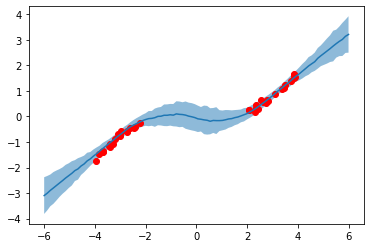

In [16]:
t.manual_seed(0)
inducing_batch = 40
net = nn.Sequential(
    bf.BiasFeature(),
    bf.KernelLIGP(in_features=2, out_features=10, inducing_batch=inducing_batch, kernel=bf.ReluKernelFeatures(inducing_batch=inducing_batch)),
    bf.KernelLIGP(in_features=10, out_features=1, inducing_batch=inducing_batch, kernel=bf.ReluKernelFeatures(inducing_batch=inducing_batch))
)
net = net.to(device=device, dtype=dtype)

train(net)
plot(net)

Global-inducing deep Gaussian processes
=====

torch.Size([100, 1])


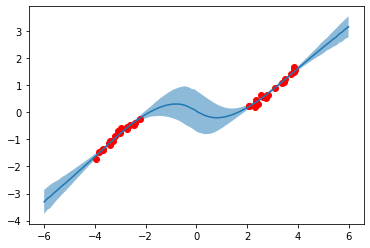

In [8]:
inducing_batch = 40
net = nn.Sequential(
    bf.BiasFeature(),
    bf.ReluKernelFeatures(inducing_batch=inducing_batch),
    bf.GIGP(out_features=10, inducing_batch=inducing_batch),
    bf.ReluKernelFeatures(inducing_batch=inducing_batch),
    bf.GIGP(out_features=1, inducing_batch=inducing_batch)
)
net = bf.InducingWrapper(net, inducing_batch=inducing_batch, inducing_data=t.linspace(-5, 5, inducing_batch)[:, None])
net = net.to(device=device, dtype=dtype)

train(net)
plot(net)

Inducing NNGP
===============

torch.Size([100, 1])


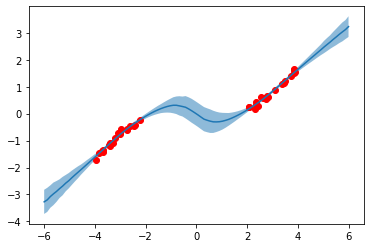

In [10]:
inducing_batch = 40
net = nn.Sequential(
    bf.BiasFeature(),
    bf.FeaturesToKernel(inducing_batch=inducing_batch),
    bf.ReluKernelGram(),
    bf.ReluKernelGram(),
    bf.GIGP(out_features=1, inducing_batch=inducing_batch)
)
net = bf.InducingWrapper(net, inducing_batch=inducing_batch, inducing_shape=(inducing_batch, 1))
net = net.to(device=device, dtype=dtype)

train(net)
plot(net)

Deep kernel processes
==========

0.47763223655223247
torch.Size([100, 1])


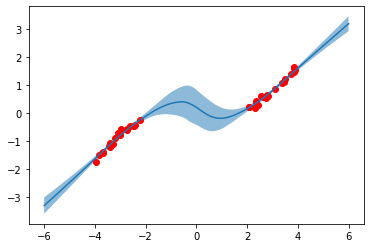

In [13]:
inducing_batch = 40
net = nn.Sequential(
    bf.BiasFeature(),
    bf.FeaturesToKernel(inducing_batch=inducing_batch),
    bf.ReluKernelGram(),    
    bf.IWLayer(inducing_batch),
    bf.ReluKernelGram(),
    bf.GIGP(out_features=1, inducing_batch=inducing_batch)
)
net = bf.InducingWrapper(net, inducing_batch=inducing_batch, inducing_data=t.linspace(-5, 5, inducing_batch)[:, None])
net = net.to(device=device, dtype=dtype)

train(net)
plot(net)

In [14]:
net[1][3].V

Parameter containing:
tensor([[-0.6937, -0.4414,  0.9947,  ...,  0.7805, -0.1908, -0.0493],
        [ 0.2922, -0.7867,  0.4324,  ...,  0.1710,  0.1606,  0.0423],
        [ 0.4886, -0.8374,  0.1996,  ..., -0.0566,  0.2152,  0.1960],
        ...,
        [-0.0725, -0.8206,  0.0750,  ..., -0.0493, -0.1845, -0.2537],
        [ 0.1541, -0.9472, -0.3496,  ..., -0.1420, -0.2161, -0.3520],
        [ 0.9913, -1.2162, -1.1031,  ..., -0.6449, -0.2924, -0.2864]],
       dtype=torch.float64, requires_grad=True)